Training set shape: (1156387, 13)
Validation set shape: (204069, 13)
Test set shape: (340115, 13)

Class distribution:
Training set: [614206 542181]
Validation set: [108147  95922]
Test set: [180065 160050]
epoch 0  | loss: 0.29266 | train_auc: 0.96919 | train_accuracy: 0.92057 | train_logloss: 0.21088 | valid_auc: 0.96913 | valid_accuracy: 0.92095 | valid_logloss: 0.211   |  0:00:40s
epoch 1  | loss: 0.20175 | train_auc: 0.97676 | train_accuracy: 0.93078 | train_logloss: 0.18334 | valid_auc: 0.97661 | valid_accuracy: 0.93034 | valid_logloss: 0.18438 |  0:01:20s
epoch 2  | loss: 0.18257 | train_auc: 0.98075 | train_accuracy: 0.93766 | train_logloss: 0.16676 | valid_auc: 0.98059 | valid_accuracy: 0.93785 | valid_logloss: 0.1674  |  0:01:59s
epoch 3  | loss: 0.16339 | train_auc: 0.98437 | train_accuracy: 0.94688 | train_logloss: 0.14921 | valid_auc: 0.98427 | valid_accuracy: 0.94654 | valid_logloss: 0.14976 |  0:02:39s
epoch 4  | loss: 0.15068 | train_auc: 0.98615 | train_accuracy: 0.947

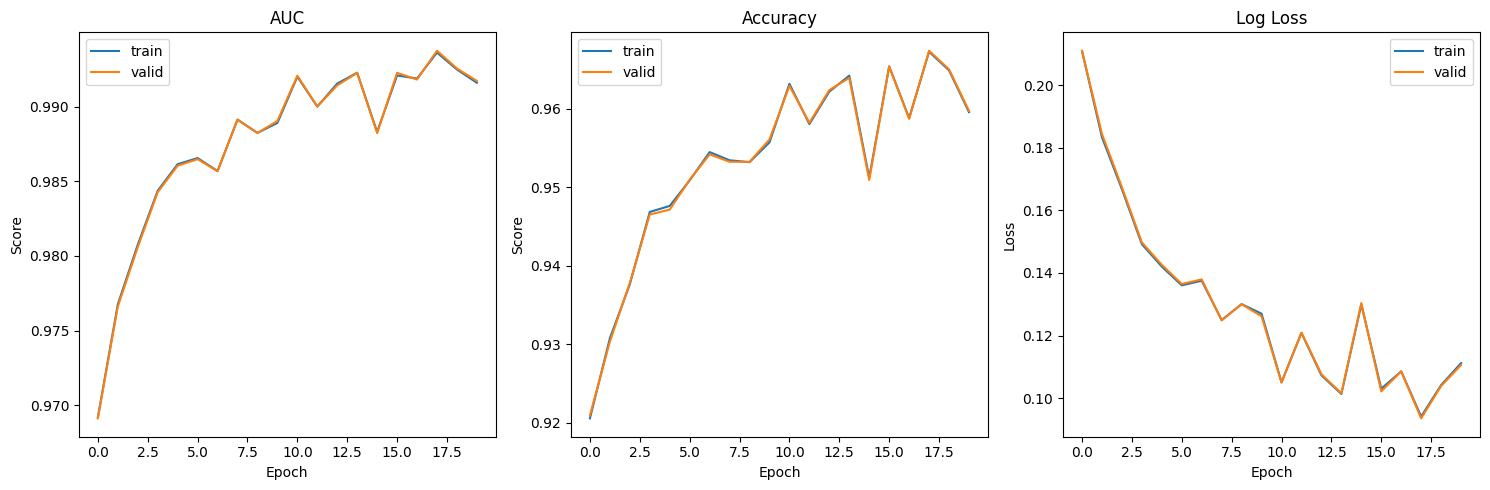


Model Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    180065
           1       0.97      0.96      0.96    160050

    accuracy                           0.97    340115
   macro avg       0.97      0.97      0.97    340115
weighted avg       0.97      0.97      0.97    340115

ROC-AUC: 0.9934
PR-AUC: 0.9936


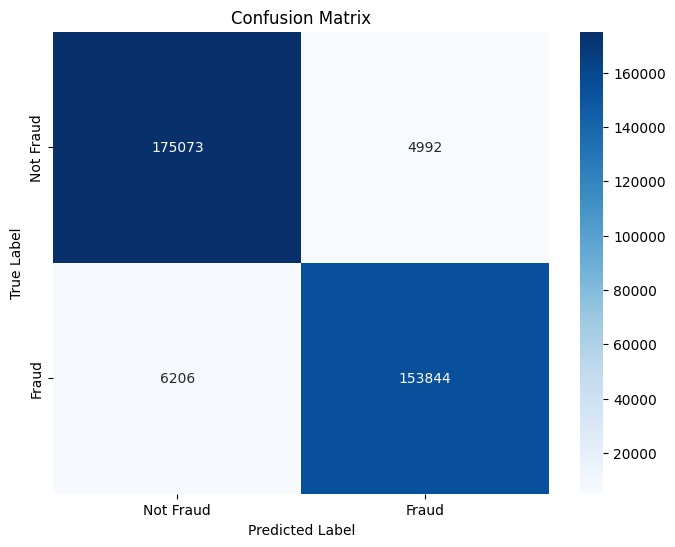


Optimal threshold: 0.5168 (F1: 0.9650)

Model Evaluation with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    180065
           1       0.97      0.96      0.96    160050

    accuracy                           0.97    340115
   macro avg       0.97      0.97      0.97    340115
weighted avg       0.97      0.97      0.97    340115



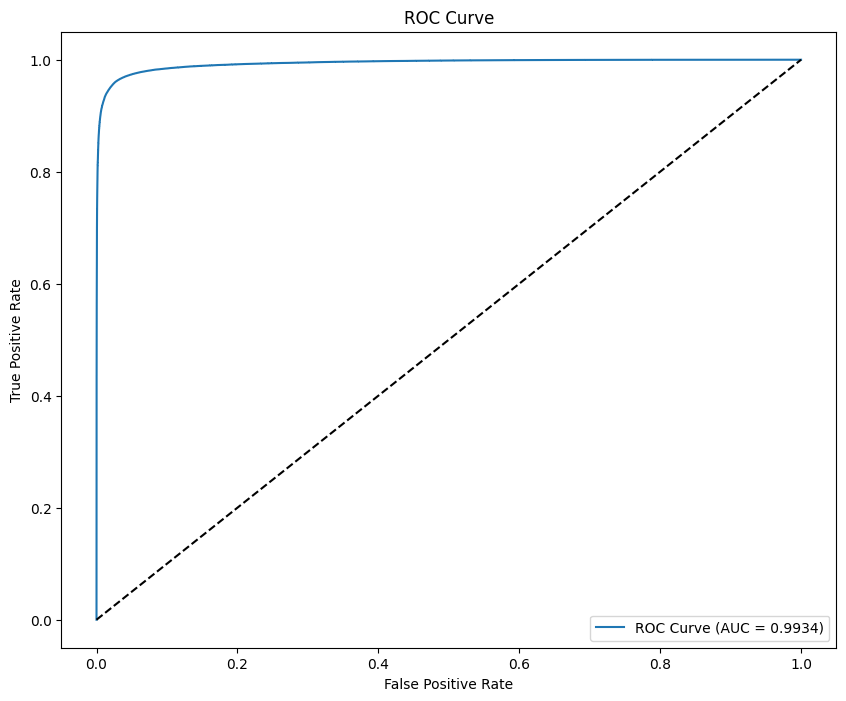

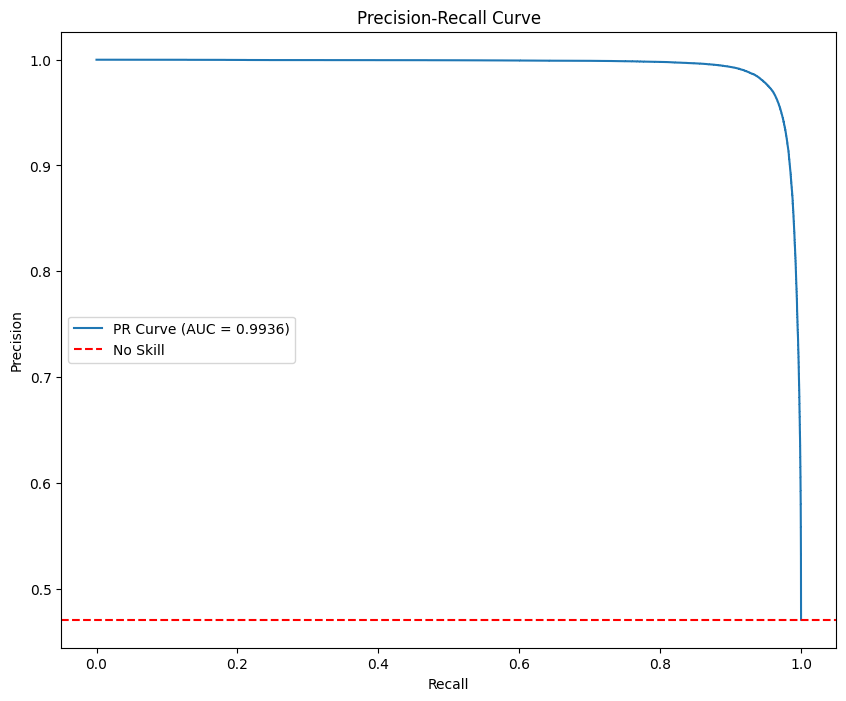

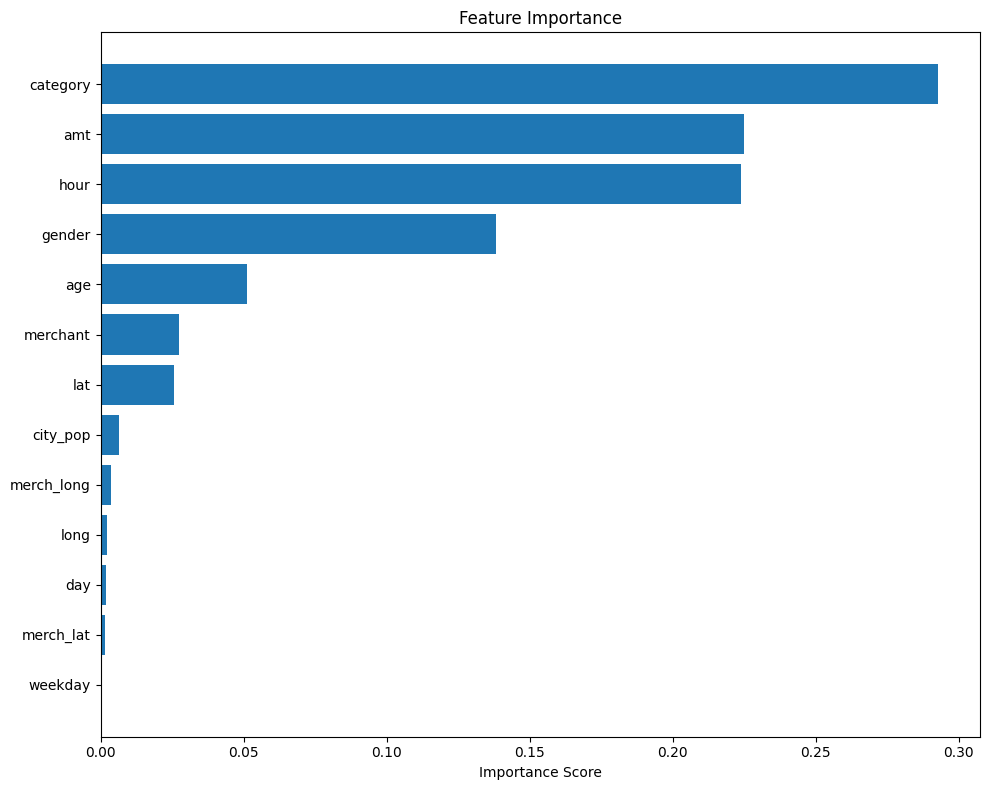


Model training and evaluation complete!


In [6]:
# TabNet for Credit Card Fraud Detection
# Complete implementation with optimized parameters and evaluation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve,
    average_precision_score, roc_curve
)
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Load the resampled data
# Assuming it's already been processed and saved to a CSV file
# Replace 'resampled_data.csv' with your actual file name
resampled_data = pd.read_csv(r'C:\Users\sarve\Desktop\credit_card_fruda\resampled_fraud_data.csv')

# Define features and target
features = [
    'amt', 'category', 'merchant', 'hour', 'weekday', 
    'lat', 'long', 'merch_lat', 'merch_long',
    'gender', 'age', 'city_pop', 'day'
]
target = 'is_fraud'

# Split data into features and target
X = resampled_data[features]
y = resampled_data[target]

# Split into training and testing sets
# Note: In a real-world scenario, consider time-based splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# Create validation set from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=seed
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Check class distribution
print("\nClass distribution:")
print(f"Training set: {np.bincount(y_train)}")
print(f"Validation set: {np.bincount(y_val)}")
print(f"Test set: {np.bincount(y_test)}")

# Define TabNet model with optimized parameters
# Define TabNet model with optimized parameters
model = TabNetClassifier(
    # Core architecture parameters
    n_d=64,                # Width of decision prediction layer
    n_a=64,                # Width of attention embedding
    n_steps=5,             # Sequential attention steps
    gamma=1.5,             # Feature selection regularization
    
    # Network complexity
    n_independent=2,       # Independent GLU layers per step
    n_shared=2,            # Shared GLU layers per step
    momentum=0.3,          # Batch normalization momentum
    
    # Regularization
    lambda_sparse=0.005,   # Sparsity regularization
    
    # Training parameters
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.002,weight_decay=1e-5),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(
        mode="min",
        patience=3,
        factor=0.3,
        verbose=True
    ),
    
    # Device and verbosity
    device_name="auto",    # Uses GPU if available
    verbose=1,
    
    # Seed for reproducibility
    seed=seed
)

# In the fit method you specify the max_epochs
model.fit(
    X_train=X_train.values, 
    y_train=y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy', 'logloss'],
    max_epochs=20,        # Maximum number of epochs
    patience=15,            # Early stopping patience
    batch_size=2048 ,       # Slightly smaller batches
    virtual_batch_size=1024  # Increased for stability
)

# Train the model


# Save the trained model
model.save_model("tabnet_fraud_model_1")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(model.history['train_auc'], label='train')
plt.plot(model.history['valid_auc'], label='valid')
plt.title('AUC')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(model.history['train_accuracy'], label='train')
plt.plot(model.history['valid_accuracy'], label='valid')
plt.title('Accuracy')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(model.history['train_logloss'], label='train')
plt.plot(model.history['valid_logloss'], label='valid')
plt.title('Log Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Evaluate on test set
y_pred = model.predict(X_test.values)
y_pred_proba = model.predict_proba(X_test.values)[:, 1]

# Calculate metrics
print("\nModel Evaluation on Test Set:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * recall * precision / (recall + precision + 1e-7)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\nOptimal threshold: {optimal_threshold:.4f} (F1: {optimal_f1:.4f})")

# Apply optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print("\nModel Evaluation with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'PR Curve (AUC = {average_precision_score(y_test, y_pred_proba):.4f})')
plt.axhline(y=len(y_test[y_test==1])/len(y_test), color='r', linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('pr_curve.png')
plt.show()

# Get feature importance
feature_importances = model.feature_importances_
feature_names = np.array(features)

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Function to evaluate on original distribution data
def evaluate_on_original_data(model, original_data_path):
    """
    Evaluates the model on the original (imbalanced) distribution
    
    Parameters:
    -----------
    model : TabNetClassifier
        Trained TabNet model
    original_data_path : str
        Path to the original data CSV file
    """
    print("\nEvaluating on original data distribution...")
    
    # Load original data
    original_data = pd.read_csv(original_data_path)
    
    # Extract features and target
    X_orig = original_data[features]
    y_orig = original_data[target]
    
    # Get predictions
    y_orig_pred = model.predict(X_orig.values)
    y_orig_pred_proba = model.predict_proba(X_orig.values)[:, 1]
    
    # Calculate metrics
    print("\nModel Evaluation on Original Distribution:")
    print(classification_report(y_orig, y_orig_pred))
    print(f"ROC-AUC: {roc_auc_score(y_orig, y_orig_pred_proba):.4f}")
    print(f"PR-AUC: {average_precision_score(y_orig, y_orig_pred_proba):.4f}")
    
    # Apply optimal threshold from resampled data
    y_orig_pred_optimal = (y_orig_pred_proba >= optimal_threshold).astype(int)
    print("\nModel Evaluation on Original Distribution with Optimal Threshold:")
    print(classification_report(y_orig, y_orig_pred_optimal))

# Uncomment to evaluate on original data
# evaluate_on_original_data(model, 'original_data.csv')

# For deployment - saving the model and important parameters
import joblib
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')

# Function for deployment
def predict_fraud(data, model_path="tabnet_fraud_model", threshold_path="optimal_threshold.pkl"):

    # Load model and threshold
    model = TabNetClassifier()
    model.load_model(model_path)
    threshold = joblib.load(threshold_path)
    
    # Ensure data has the correct features
    required_features = features
    missing_features = set(required_features) - set(data.columns)
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    
    # Select only the required features in the correct order
    X = data[required_features].values
    
    # Get predictions
    probabilities = model.predict_proba(X)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    
    return predictions, probabilities

# Example usage (uncomment to use)
# new_data = pd.read_csv('new_transactions.csv')
# fraud_predictions, fraud_probabilities = predict_fraud(new_data)
# new_data['fraud_prediction'] = fraud_predictions
# new_data['fraud_probability'] = fraud_probabilities
# new_data.to_csv('predictions.csv', index=False)

print("\nModel training and evaluation complete!")

In [9]:
 # Class predictions